In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import Xception
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np

In [2]:
# Load the dataset
dataset_path = r"D:\CS-colleage\first_term\deep-learning\weather-detection\dataSet\dataset"
normalization_layer = layers.Rescaling(1./255)

# Load full dataset
full_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)

# Split the dataset
data_size = len(full_dataset)
train_size = int(0.7 * data_size)
val_size = int(0.15 * data_size)
test_size = data_size - train_size - val_size

train_dataset = full_dataset.take(train_size)
remaining_dataset = full_dataset.skip(train_size)
validation_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

# Normalize the datasets
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 6862 files belonging to 11 classes.


In [3]:
# Data augmentation for training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch datasets
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



In [4]:
# Load the pre-trained Xception model
base_model = Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze Entry Flow and Middle Flow layers
for layer in base_model.layers[:-36]:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(len(full_dataset.class_names), activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Initial model built and compiled.")



Initial model built and compiled.


In [5]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

print("Initial training complete.")

# Save the model after initial training
model.save('weather_detection_model_initial.h5')
print("Model saved after initial training.")


Epoch 1/10


150/150 [==============================] - 840s 6s/step - loss: 1.7301 - accuracy: 0.4321 - val_loss: 0.8063 - val_accuracy: 0.7188
Epoch 2/10
150/150 [==============================] - 804s 5s/step - loss: 0.7694 - accuracy: 0.7550 - val_loss: 0.4339 - val_accuracy: 0.8594
Epoch 3/10
150/150 [==============================] - 719s 5s/step - loss: 0.5674 - accuracy: 0.8188 - val_loss: 0.4181 - val_accuracy: 0.8643
Epoch 4/10
150/150 [==============================] - 631s 4s/step - loss: 0.4753 - accuracy: 0.8485 - val_loss: 0.3658 - val_accuracy: 0.8896
Epoch 5/10
150/150 [==============================] - 609s 4s/step - loss: 0.4141 - accuracy: 0.8748 - val_loss: 0.3621 - val_accuracy: 0.8906
Epoch 6/10
150/150 [==============================] - 598s 4s/step - loss: 0.3822 - accuracy: 0.8792 - val_loss: 0.4079 - val_accuracy: 0.8799
Epoch 7/10
150/150 [==============================] - 640s 4s/step - loss: 0.3416 - accuracy: 0.8929 - val_loss: 0.4275 - val_accuracy: 0.86

C:\Users\Fatma Sokar\Documents\---\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved after initial training.


In [16]:
# Fine-tune the model

# Unfreeze deeper layers for fine-tuning
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

print("Fine-tuning model with unfrozen layers...")

# Fine-tune the model for 5 epochs
history_fine_tuning = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,  # Fine-tuning for fewer epochs
    steps_per_epoch=len(train_dataset),
    validation_steps=len(validation_dataset),
# initial_epoch=history.epoch[-1]  # Continue from the previous training epoch
)

print("Fine-tuning complete.")

# Evaluate the fine-tuned model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy after Fine-Tuning: {test_accuracy * 100:.2f}%")


Fine-tuning model with unfrozen layers...
Epoch 1/5
150/150 [==============================] - 1294s 8s/step - loss: 0.2477 - accuracy: 0.9173 - val_loss: 0.3814 - val_accuracy: 0.8936
Epoch 2/5
150/150 [==============================] - 1022s 7s/step - loss: 0.2422 - accuracy: 0.9181 - val_loss: 0.3616 - val_accuracy: 0.8945
Epoch 3/5
150/150 [==============================] - 1237s 8s/step - loss: 0.2263 - accuracy: 0.9267 - val_loss: 0.3571 - val_accuracy: 0.8994
Epoch 4/5
150/150 [==============================] - 905s 6s/step - loss: 0.2214 - accuracy: 0.9290 - val_loss: 0.3363 - val_accuracy: 0.8965
Epoch 5/5
150/150 [==============================] - 1171s 8s/step - loss: 0.2228 - accuracy: 0.9275 - val_loss: 0.3301 - val_accuracy: 0.9023
Fine-tuning complete.
33/33 [==============================] - 90s 2s/step - loss: 0.3589 - accuracy: 0.8950
Test Accuracy after Fine-Tuning: 89.50%


In [17]:
# Combine all test data for evaluation
def concatenate_datasets(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch)
        labels.append(label_batch)
    return tf.concat(images, axis=0), tf.concat(labels, axis=0)

test_images, test_labels = concatenate_datasets(test_dataset)

# Predictions and metrics
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report
print("\nClassification Report:\n")
class_names = full_dataset.class_names
print(classification_report(test_labels, predicted_classes, target_names=class_names))


33/33 [==============================] - 97s 3s/step

Classification Report:

              precision    recall  f1-score   support

         dew       0.90      0.99      0.94        90
     fogsmog       0.89      0.98      0.93       122
       frost       0.81      0.84      0.83        70
       glaze       0.79      0.78      0.78        86
        hail       0.96      0.95      0.95       112
   lightning       0.98      1.00      0.99        59
        rain       0.90      0.90      0.90        73
     rainbow       1.00      1.00      1.00        30
        rime       0.88      0.91      0.89       180
   sandstorm       0.97      0.89      0.93       116
        snow       0.85      0.70      0.77       100

    accuracy                           0.90      1038
   macro avg       0.90      0.90      0.90      1038
weighted avg       0.90      0.90      0.90      1038



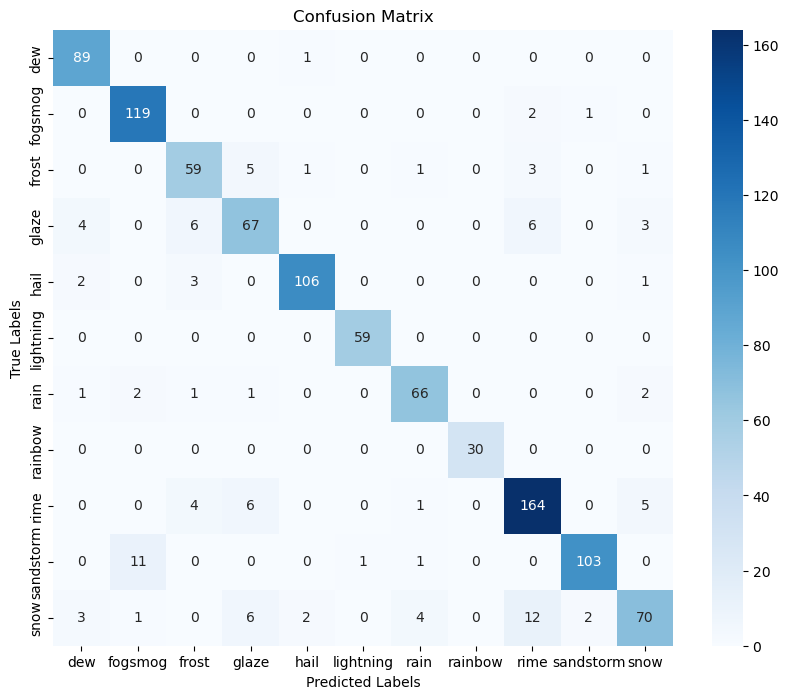

In [18]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

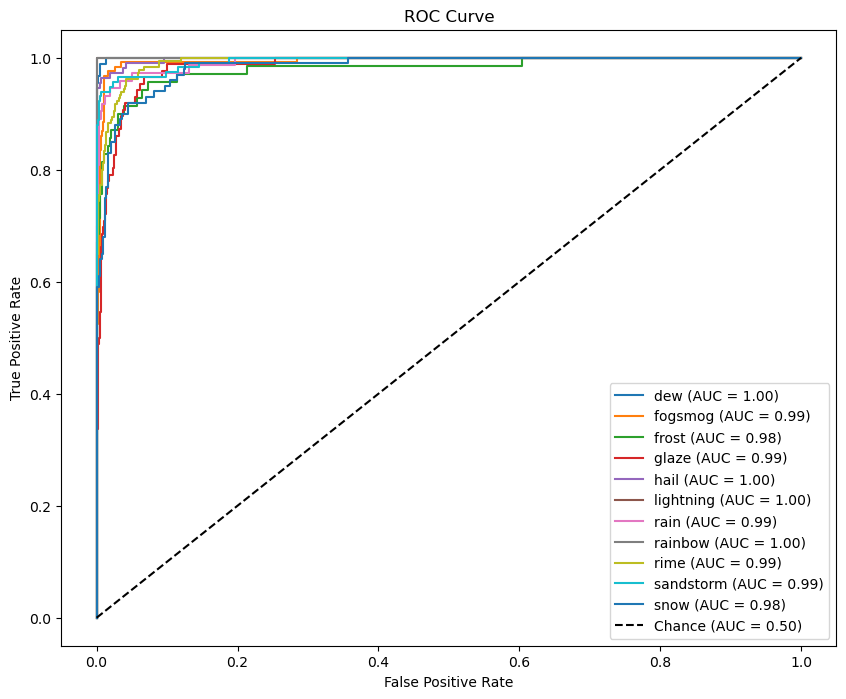

In [19]:
# ROC and AUC for Multi-Class
true_classes_binarized = label_binarize(test_labels, classes=np.arange(len(class_names)))

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

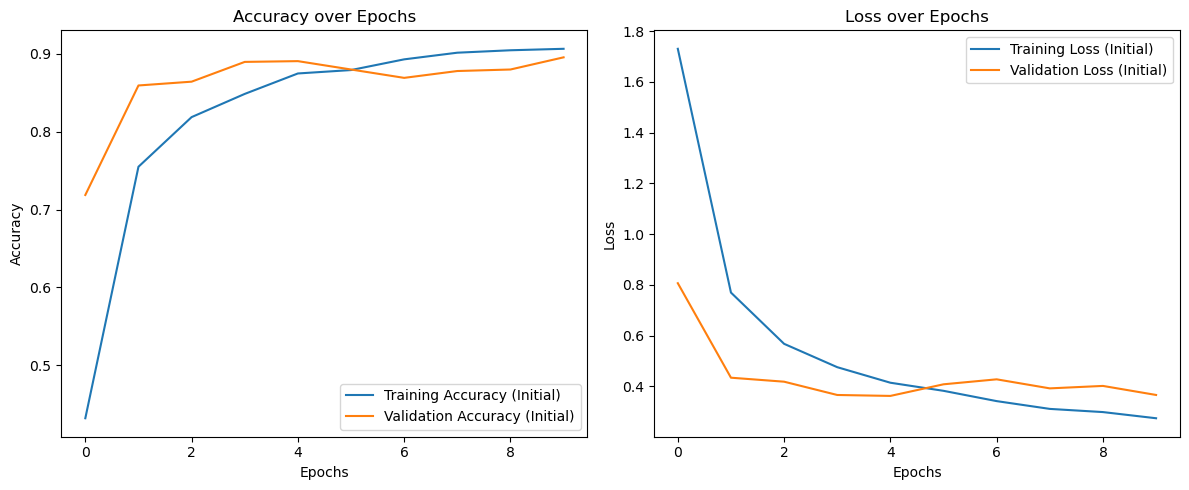

In [21]:
# Function to plot training and validation accuracy and loss
def plot_history(initial_history, fine_tuning_history=None):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(initial_history.history['accuracy'], label='Training Accuracy (Initial)')
    plt.plot(initial_history.history['val_accuracy'], label='Validation Accuracy (Initial)')

    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(initial_history.history['loss'], label='Training Loss (Initial)')
    plt.plot(initial_history.history['val_loss'], label='Validation Loss (Initial)')

    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the plot function
plot_history(history, history_fine_tuning)
